# Predicting Demand for Rental Bikes

This undertakes linear regression, decision tree analysis, and random forest analysis to predict the number of bike rentals that occur in a given day/hour/month.  The data comes from bike rentals in Washington DC over the time period 2011 to 2012.  This data was compiled Hadi Fanaee-T at the University of Porto.  The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. The data also includes variables on weather that can affect bike rentals.  The data can be obtained from the University of California, Irvine's website.

In [21]:
import pandas as pd

bike_rentals = pd.read_csv("bike_rental_hour.csv")
print(bike_rentals.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


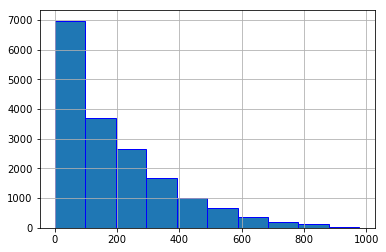

In [22]:
%matplotlib inline

bike_rentals["cnt"].hist(edgecolor="blue")

### Correlations between the different RHS variables and LHS.

Examining the correlations between the different variables we observed that instant, season, year, month are all highly correlated.  This suggests that we should not include this variable with season, month, year.  weathersit is also highly correlated with humidity; casual is highly correlated with temperature and humidity.  Atemp and temp are highly correlated.  The variance inflation factor (VIF = 1/(1-R^2)) over 2.50 (or R^2 = 0.60) provides an indication of potential multicollinearity.  Multicollinearity is not an issue if we are only concerned with prediction and not interpretation of the variable of interest estimates.  It is also not a concern when it is simply a factor (non-linear) to other variables included in the model or categorical dummy variables.

Registered plus causal equal cnt and therefore are alternative outcome variable to analyze.

In [25]:
#examine how various variables are correlated with cnt
corrbike = bike_rentals.corr()
print(corrbike["cnt"])
#print(corrbike)

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64


In [26]:
# place the hours into different time periods
def assign_label(hr):
    if 6 < hr and hr <= 12:
        return 1
    elif 12 < hr and hr <= 18:
        return 2
    elif 18 < hr and hr <= 24:
        return 3
    elif 0 <= hr and hr <= 6:
        return 4
    
bike_rentals["time_label"]=bike_rentals.apply(lambda x: assign_label(x["hr"]), axis=1)
print(bike_rentals.head(10))

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   
5        6  2011-01-01       1   0     1   5        0        6           0   
6        7  2011-01-01       1   0     1   6        0        6           0   
7        8  2011-01-01       1   0     1   7        0        6           0   
8        9  2011-01-01       1   0     1   8        0        6           0   
9       10  2011-01-01       1   0     1   9        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  \
0           1  0.24  0.2879  0.81     0.0000       3          13   1

#### Chosing an error metric

Mean squared error is chosen because it follows from standard linear regressions.  Since the variable bike count can be considered continous it makes sense to choose this value.  Moreover this statistic tends to weigh values further away from the norm more significantly.

In [27]:
#shuffle the data to make sure we are drawing random subset
import numpy as np
import math

randind = np.random.permutation(len(bike_rentals))
shuffled_bike_rentals=bike_rentals.loc[randind]
train = shuffled_bike_rentals.iloc[0:math.floor(len(bike_rentals)*0.80)]

#select any rows in bike_rentals that aren't in train to be in testing set
test = shuffled_bike_rentals.loc[~bike_rentals.index.isin(train.index)]

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

#grab columns that have a high correlation, but not so high that it is nearly perfect
#we also only include columns that are not too highly correlated with each other due to reasons of multicollinearity
cols = ["weathersit", "temp", "hum", "weekday", "workingday"]

#create various dummy variables
bike_rentals = pd.concat([bike_rentals, pd.get_dummies(bike_rentals['yr'], prefix="yr")], axis=1)
bike_rentals = pd.concat([bike_rentals, pd.get_dummies(bike_rentals['season'], prefix="season")], axis=1)
bike_rentals = pd.concat([bike_rentals, pd.get_dummies(bike_rentals['mnth'], prefix="mt")], axis=1)
bike_rentals = pd.concat([bike_rentals, pd.get_dummies(bike_rentals['time_label'], prefix="time")], axis=1)

#This grabs the variables with year and puts into a label name for the regression
colnames = train.columns
for c in colnames:
    if c.startswith("yr_",0) | c.startswith("mt_",0) | c.startswith("season_",0) | c.startswith("time_",0):
        cols.append(c)
#print(cols)

lr = LinearRegression()
lr.fit(train[cols],train["cnt"])
pr_y = lr.predict(train[cols])
mse_train = mean_squared_error(train["cnt"],pr_y)
pr_y = lr.predict(test[cols])
mse_test = mean_squared_error(test["cnt"],pr_y)
print("MSE train: {}".format(round(mse_train,2)))
print("MSE test:  {}".format(round(mse_test,2)))


MSE train: 19367.21
MSE test:  19265.02


### Prediction results

The predictions give a very high mean squared error indicating that the fit is not very good between predictions and actual values.  At the same time the difference in MSE between train and test models is not large.

In [40]:
#applying the decision tree

from sklearn.tree import DecisionTreeRegressor

cols = ["weathersit", "temp", "hum", "weekday", "workingday", "yr", "season", "mnth", "time_label"]
dt = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=15, min_samples_leaf=2)
dt.fit(train[cols], train["cnt"])
pr_train = dt.predict(train[cols])
mse_train = mean_squared_error(train["cnt"],pr_train)
pr_test = dt.predict(test[cols])
mse_test = mean_squared_error(test["cnt"],pr_test)
print("MSE train: {}".format(round(mse_train,2)))
print("MSE test:  {}".format(round(mse_test,2)))


dt = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=15, min_samples_split=8, min_samples_leaf=2)
dt.fit(train[cols], train["cnt"])
pr_train = dt.predict(train[cols])
mse_train = mean_squared_error(train["cnt"],pr_train)
pr_test = dt.predict(test[cols])
mse_test = mean_squared_error(test["cnt"],pr_test)
print("MSE train: {}".format(round(mse_train,2)))
print("MSE test:  {}".format(round(mse_test,2)))

MSE train: 6591.86
MSE test:  7717.76
MSE train: 6277.2
MSE test:  7709.6


### Decision tree analysis results

The decision tree analysis significantly improves the mean squared error cutting it down
by more than half of the error of the linear regression.  The mean-squared error, however, still remains high.  The benefit of the decision tree is that it executes fast and can handle non-linearities in the data that are not possible to be handled by a linear regression.  However, its limitations is that it has a tendency to overfit (i.e. introduce increased error into the test model set), but this can be somewhat corrected by limiting the depth, sample split, and leaves in the tree.  Also overfitting tends to arise when variable have multicollinearity as the decision tree will choose the best one that may be good for the train model, but not for the test set.

In [31]:
#Applying a random forest

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=15, criterion='mse', max_depth=7, min_samples_split=6, min_samples_leaf=1)
rf.fit(train[cols], train["cnt"])
pr_train = rf.predict(train[cols])
mse_train = mean_squared_error(train["cnt"],pr_train)
pr_test = rf.predict(test[cols])
mse_test = mean_squared_error(test["cnt"],pr_test)
print("MSE train: {}".format(round(mse_train,2)))
print("MSE test:  {}".format(round(mse_test,2)))


MSE train: 11714.01
MSE test:  11584.0


In [44]:
rf = RandomForestRegressor(n_estimators=15, criterion='mse', max_depth=None, min_samples_split=10, min_samples_leaf=2)
rf.fit(train[cols], train["cnt"])
pr_train = rf.predict(train[cols])
mse_train = mean_squared_error(train["cnt"],pr_train)
pr_test = rf.predict(test[cols])
mse_test = mean_squared_error(test["cnt"],pr_test)
print("MSE train: {}".format(round(mse_train,2)))
print("MSE test:  {}".format(round(mse_test,2)))

MSE train: 5883.1
MSE test:  6678.07


### Random Forest Results

The random forest regressor is a slight improvement over the decision tree analysis model.  However, the mean-squared-error still is high.  The benefits of the random forest comes through its accuracy.  Nevertheless, the random model is more difficult to interpret as it hard to tell what parameters are driving the estimates and takes longer to execute compared to linear regression or decision tree models.

### Extensions:  Creating a Weather Index

The combined weather could have have a non-linear effect in regression estimates.  Therefore combining the three variables into single index could add additional predictive power to the regression algorithms.  Below an index based on principal component analysis is used to repeat the regression exercises above.

In [81]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import scale

#here we just the principal component
pca = PCA(n_components=3)
#now we need to scale the values before using in the PCA
pcavars = scale(bike_rentals[["weathersit", "temp", "hum"]])
pca.fit(pcavars)
#The amount of variance that each PC explains
var= pca.explained_variance_ratio_
#examine how much is explained by the various components
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
#print(var1)

#from the cumulative sum of the variance we see that the first two explain about 80%
#for ease of analysis we will currently only use 1 PCA.
pca = PCA(n_components=1)
pca.fit(pcavars)
#bike_rentals["TempI1"] = pca.fit_transform(pcavars)
pca_comp = pca.fit_transform(pcavars)
#print(pca_comp)
#transform variables into ones that we can use in the regression
pca_c1 = []
for comp in pca_comp:
    for item in comp:
        pca_c1.append(item)
bike_rentals["WeatherI1"] = pca_c1

#get only the first principal component (column)
#print(pca.fit_transform(bike_rentals[["weathersit", "temp", "hum"]]))
#print(pca.get_params())
#fact = FactorAnalysis()
#fact.fit(bike_rentals["weathersit", "temp", "hum"])
#fact.fit_transform(bike_rentals["weathersit", "temp", "hum"])




In [82]:
randind = np.random.permutation(len(bike_rentals))
shuffled_bike_rentals=bike_rentals.loc[randind]
train = shuffled_bike_rentals.iloc[0:math.floor(len(bike_rentals)*0.80)]

#select any rows in bike_rentals that aren't in train to be in testing set
test = shuffled_bike_rentals.loc[~bike_rentals.index.isin(train.index)]

cols = ["WeatherI1","weathersit", "temp", "hum","weekday", "workingday"]
colnames = train.columns
for c in colnames:
    if c.startswith("yr_",0) | c.startswith("mt_",0) | c.startswith("season_",0) | c.startswith("time_",0):
        cols.append(c)

lr = LinearRegression()
lr.fit(train[cols],train["cnt"])
pr_y = lr.predict(train[cols])
mse_train = mean_squared_error(train["cnt"],pr_y)
pr_y = lr.predict(test[cols])
mse_test = mean_squared_error(test["cnt"],pr_y)
print("MSE train: {}".format(round(mse_train,2)))
print("MSE test:  {}".format(round(mse_test,2)))


MSE train: 14771.27
MSE test:  15124.68


In [85]:
cols = ["WeatherI1","weathersit", "temp", "hum", "weekday", "workingday", "yr", "season", "mnth", "time_label"]
dt = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=15, min_samples_split=8, min_samples_leaf=2)
dt.fit(train[cols], train["cnt"])
pr_train = dt.predict(train[cols])
mse_train = mean_squared_error(train["cnt"],pr_train)
pr_test = dt.predict(test[cols])
mse_test = mean_squared_error(test["cnt"],pr_test)
print("MSE train: {}".format(round(mse_train,2)))
print("MSE test:  {}".format(round(mse_test,2)))

MSE train: 5908.36
MSE test:  7415.36


In [86]:
rf = RandomForestRegressor(n_estimators=15, criterion='mse', max_depth=None, min_samples_split=10, min_samples_leaf=2)
rf.fit(train[cols], train["cnt"])
pr_train = rf.predict(train[cols])
mse_train = mean_squared_error(train["cnt"],pr_train)
pr_test = rf.predict(test[cols])
mse_test = mean_squared_error(test["cnt"],pr_test)
print("MSE train: {}".format(round(mse_train,2)))
print("MSE test:  {}".format(round(mse_test,2)))

MSE train: 5462.01
MSE test:  6383.3


## Conclusions 

The additional index developed from PCA improves the estimates for the linear regression, but introduces additional error into into the test model for decision tree estimates.  There is also marginal improvements in the error for the MSE test model using a random forest estimator.  In general, if we care about accuracy the random forest provides the best model, however, for speed and interpretation the decision tree regressor may be a balanced option that provides significantly more accuracy over a linear regression and better performance speed.